# Chapter 4: Multilingual Named Entity Recognition

## On Fine-tuning ... to perform token classification (NER)

### General workflow

The workflow for the task of fine-tuning an existing model for token classfication can be broken down into for major tasks:

* preparing a dataset for fine-tuning
* preparing an appropriate head and configuration to use over the existing model
* prepare performance metrics, training arguments, and a data collator
* lastly, train your model and evaluate the results

#### Prepare dataset

1. Obtain a dataset.

1. Add any neccessary features to the dataset(s) required for token classification. In the case of NER and our dataset, the `ner_tags` feature have values that are `int` indicating the class. Since we would like to use the IOB2 format, we use `map()` and `ClassLabel.int2str()` to add another dataset feature containing the IOB2 tag strings corresponding to the `ner_tags` class `int` value.

1. Tokenize the training dataset according to your needs. _Make sure you have an appropriate tokenizer!_


#### Prepare custom model head that wraps an existing base model

1. Create a custom model for token classification. Ideally, this should wrap an existing base model and use the logits of that to classify the named entity tokens. In our case, we extend `transformers.models.roberta.modeling_roberta.RobertaPretrainedModel`, implementing `__init__` and `forward`.

1. Prepare a corresponding configuration object for our model. We can leverage [`transformer.AutoConfig.from_pretrained`](https://huggingface.co/docs/transformers/v4.26.1/en/model_doc/auto#transformers.AutoConfig.from_pretrained), passing in the model's name, the `num_labels` for the number of NER types (classes), and dictionaries mapping `id2label` and `label2id`.

1. Test this model and configuration on an example input.


#### Prepare for fine-tuning

1. Prepare performance metrics.

1. Prepare training arguments

1. Prepare data collator


#### Train and review metrics

1. Train

1. Review metrics

1. Perform error analysis

## The Dataset

... Check out the [xtreme](https://huggingface.co/datasets/xtreme) dataset on Huggingface.


In [1]:
from datasets import get_dataset_config_names, load_dataset

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [2]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

----

In [3]:
from collections import defaultdict
from datasets import DatasetDict

# the major languages in Switzerland!
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

panx_ch = defaultdict(DatasetDict)

for lang,frac in zip(langs, fracs):
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
                .shuffle(seed=0)
                .select(range(int(frac * ds[split].num_rows)))
        )

In [4]:
import pandas as pd

pd.DataFrame(
    {lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
    index=["Number of training examples"]
)

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [5]:
print(panx_ch)

defaultdict(<class 'datasets.dataset_dict.DatasetDict'>, {'de': DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
}), 'fr': DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 4580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 2290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 2290
    })
}), 'it': DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 1680
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 840
    })
    test: Dataset({
        features: ['token

In [6]:
element = panx_ch["de"]["train"][0]
print(type(element))
for key, value in element.items():
    print(f"{key}: {value}")

<class 'dict'>
tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [7]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [8]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [9]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

In [10]:
panx_de = panx_ch["de"].map(create_tag_names)

In [11]:
print(panx_de)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})


In [12]:
de_example = panx_de["train"][0]
pd.DataFrame(
    [de_example["tokens"], de_example["ner_tags_str"]],
    ["Tokens", "Tags"]
)

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [13]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(
    split2freqs,
    orient="index"
)

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


## Multilingual Transformers

XLM-Roberta supports 100 languages, Japanese included!

Suggested reading:

* [A. Conneau, K. Khandelwal, et al.; 2020; "Unsupervised Cross-lingual Representation Learning at Scale"](https://arxiv.org/pdf/1911.02116.pdf)
* [T. Kudo, J. Richardson; 2018; "SentencePiece: A Simple and Language Independent Subword Tokenizer and Detokenizer for Neural Text Processing"](https://arxiv.org/pdf/1808.06226.pdf)

----

## A Closer Look at Tokenization

In [14]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [15]:
text = "Jack Sparrow loves New York!"

In [16]:
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [17]:
print(f"BERT tokens: {bert_tokens}")
''.join(bert_tokens)

BERT tokens: ['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']


'[CLS]JackSpa##rrowlovesNewYork![SEP]'

In [18]:
print(f"XML-R tokens: {xlmr_tokens}")
''.join(xlmr_tokens).replace(u'\u2581', ' ')

XML-R tokens: ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


'<s> Jack Sparrow loves New York!</s>'

Suggested reading:

* [J. Devlin, et al., "BERT: Pre-Training of Deep Bidirectional Transformers for Language Understanding"](https://arxiv.org/abs/1810.04805)

----

## Creating a Custom Model for Token Classification

Or, How to build a custom head for any task and just mount it on top of a pretrained model.

In [19]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [20]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig
    
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        
        # load model body!
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        
        # set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        
        # load and initialize weights
        self.init_weights()


    def forward(
        self, 
        input_ids=None, 
        attention_mask=None, 
        token_type_ids=None,
        labels=None,
        **kwargs
    ):
        # use model body to get encoder representations
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            **kwargs
        )
        
        # apply classifier to encoding representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        
        # calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                logits.view(-1, self.num_labels),
                labels.view(-1)
            )
        
        # return
        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

----

## Loading a Custom Model



In [21]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [22]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(
    xlmr_model_name,
    num_labels=tags.num_classes,
    id2label=index2tag,
    label2id=tag2index
)

In [23]:
print(xlmr_config)

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}



In [24]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")

pd.DataFrame(
    [xlmr_tokens, input_ids[0].numpy()],
    index = ["Tokens", "Inputs IDs"]
)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Inputs IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [26]:
outputs = xlmr_model(input_ids.to(device)).logits

predictions = torch.argmax(outputs, dim=2)

print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [27]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame(
    [xlmr_tokens, preds],
    index = ["Tokens", "Tags"]
)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC


In [28]:
def tag_text(text, tags, model, tokenizer):
    # get tokens with special characters
    tokens = tokenizer(text).tokens()
    
    # encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    
    # get prediction as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    
    # take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    
    # convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    
    return pd.DataFrame([tokens, preds], index = ["Tokens", "Tags"])
    

----

## Tokenizing Texts for NER

   `function(examples: Dict[str, List]) -> Dict[str, List]`

In [29]:
words, labels = de_example["tokens"], de_example["ner_tags"]

_what is `is_split_into_words`?_

In [30]:
tokenized_input = xlmr_tokenizer(
    de_example["tokens"], 
    is_split_into_words=True
)

tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


_what is `word_ids`?_

In [31]:
word_ids = tokenized_input.word_ids()

pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [32]:
previous_word_index = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_index:
        label_ids.append(-100)
    elif word_idx != previous_word_index:
        label_ids.append(labels[word_idx])
    previous_word_index = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index  = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame(
    [tokens, word_ids, label_ids, labels],
    index = index
)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [33]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(
        examples["tokens"],
        truncation = True,
        is_split_into_words = True
    )
    
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [34]:
def encode_panx_dataset(corpus):
    return corpus.map(
        tokenize_and_align_labels, 
        batched = True,
        remove_columns = [ "langs", "ner_tags", "tokens" ]
    )
                      

In [35]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [36]:
print(panx_de_encoded)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
})


----

## Performance Measures

`seqeval` is a Python framework for sequence labeling evaluation. Check out [chakki-works/seqeval on Github](https://github.com/chakki-works/seqeval).

Also see the [Metrics Card for `seqeval` on huggingface](https://huggingface.co/spaces/evaluate-metric/seqeval).

#### Regarding the `seqeval` output...

##### precision

* _How many of the __retrieved__ items are actually relevant?_
* $Precision = \frac{\text{TP}}{\text{TP } + \text{ FP}}$
* _Also known as __positive predictive value___


##### recall

* _How many of the __relevant__ items were actually retrieved?_
* $Recall = \frac{\text{TP}}{\text{TP } + \text{ FN}}$
* _Also known as __sensitivity___

##### F1-score

* _A single metric combining both precision and recall via the harmonic mean_
* _Approximately the average of the two when they are close._
* _Coincides with the square of the geometric mean divided by the arithmetic mean._
* $F = 2 \times \frac{\text{precision } \times \text{ recall}}{\text{precision } + \text{ recall}}$
* _Also known as __$F_{1}$-measure___
* _Is a special case of the general $F_{\beta}$ measure: $F_{\beta} = (1 + \beta^2) \space \times \space \frac{\text{precision } \times \text{ recall}}{\beta2 \space \times \text{ precision } + \text{ recall}}$_

##### support

* the number of actual items belonging the the class in question

##### micro average vs macro average vs weighted average

... see [this answer to the question "Micro Average vs Macro average Performance in a Multiclass classification setting" on the Data Science Stack Exchange](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/24051#24051)...

... and [another on macro average vs weighted average in `sklearn.metrics.classification_report`](https://datascience.stackexchange.com/questions/65839/macro-average-and-weighted-average-meaning-in-classification-report)



In [37]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]

y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



----

## Fine-tuning XLM-RoBERTa

### Create `TrainingArguments`

* Before instantiating your `Trainer`, create a `TrainingArguments` to access all the points of customization during training. In this example, our arguments encompass things like:
   * `output_dir` ... output directory where the model predictions and checkpoints will be written.
   * `log_level`
   * `num_train_epochs`
   * `per_device_train_batch_size`
   * `save_steps`
   * `logging_steps`
   <br/>... among other things... <p/>
* During training, if you do not take certain steps, you may see a warning message when invoking `trainer.train()`:

<pre>
/opt/conda/envs/transformers-py38/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
</pre>

To avoid this, try explicitly using the `adamw_torch` optimizer in your training arguments.

In [38]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"

training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    optim="adamw_torch",    # let's get rid of that annoying warning message
)

In [39]:
from huggingface_hub import notebook_login

# no error, means this call succeeded!
#
# you can click on the log entries icon in the lower
# left-hand portion of the window pane to see the
# logging messages indicating whether login
# succeeded or not
notebook_login()

----

### Create `transformers.Trainer`

In this example, we specify the following arguments when instantiating [`transformers.Trainer`](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer):

##### `model_init` 
*  A function that instantiates the model to be used. If provided, each call to `train()` will start from a new instance of the model as given by this function.

##### `args` 
* define a `TrainingArguments` object instance that will contain all the hyperparameters the `Trainer` will use for training and evaluation.

##### `data_collator`
* The function to use to form a batch from a list of elements of train_dataset or eval_dataset. Will default to `default_data_collator(){ if no tokenizer is provided, an instance of DataCollatorWithPadding otherwise.

##### `compute_metrics`
* The function that will be used to compute metrics at evaluation. Must take a `EvalPrediction` and return a dictionary string to metric values.

##### `train_dataset`
* The dataset to use for training. If it is a `Dataset`, columns not accepted by the `model.forward()` method are automatically removed.

##### `eval_dataset`
* The dataset to use for evaluation. If it is a `Dataset`, columns not accepted by the `model.forward()` method are automatically removed. If it is a dictionary, it will evaluate on each dataset prepending the dictionary key to the metric name.

##### `tokenizer`
* The tokenizer used to preprocess the data. If provided, will be used to automatically pad the inputs to the maximum length when batching inputs, and it will be saved along the model to make it easier to rerun an interrupted training or reuse the fine-tuned model.


OK, let's get into the more important details of `Trainer`...

### `model_init`

An argument when creating an instance of the `Trainer` object itself, this helper function will let us instantiate new model instance with each call to `Trainer.train()`.

Here, note that we using the `from_pretrained` function in our custom `XLMRobertaForTokenClassification` class, passing in:
* `xlmr_model_name`
* `xlmr_config`

Note that we also put this newly-created model instance on the `device` (GPU), and then return a handle to that instance.

In [40]:
def model_init():
    return (
        XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device)
    )

### `compute_metrics`

A function called during training to calculate statistics.

This function must take an instance of [`EvalPrediction`](https://huggingface.co/docs/transformers/v4.26.1/en/internal/trainer_utils) as its sole argument, and then return a dictionary of string to metric values. This `EvalPrediction` argument has the following properties for use when calculating training statistics:
* `predictions` (`np.ndarray`) — Predictions of the model.
* `label_ids` (`np.ndarray`) — Targets to be matched.
* `inputs` (`np.ndarray`, optional) — 

In [41]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # ignore label IDS == -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)
    
    return preds_list, labels_list

In [42]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(
        eval_pred.predictions, 
        eval_pred.label_ids
    )
    return {"f1": f1_score(y_true, y_pred)}

### `data_collator`

* Data collators are objects that will form a batch by using a list of dataset elements as input. These elements are of the same type as the elements of `train_dataset` or `eval_dataset`.

* Here, we use an instance of [`transformers.DataCollatorForTokenClassification`](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/data_collator#transformers.DataCollatorForTokenClassification), passing in our `xlmr_tokenizer` tokenizer, which as `XLMRobertaTokenizerFast` is a subclass of [`transformers.PreTrainedTokenizerFast`](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/tokenizer#transformers.PreTrainedTokenizerFast). This is a case of one of the advantages of leveraging huggingface's abstraction.

In [43]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

### `transformers.Trainer`

Instantiate [`transformers.Trainer`](), passing in all of our custom objects and data needed for fine-tuning.

In [44]:
from transformers import Trainer

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=panx_de_encoded["train"],
    eval_dataset=panx_de_encoded["validation"],
    tokenizer=xlmr_tokenizer,
)

Cloning https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-de into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Download file pytorch_model.bin:   0%|          | 16.0k/1.03G [00:00<?, ?B/s]

Download file runs/May05_03-56-23_instance-1/events.out.tfevents.1683260192.instance-1.1908.0:  59%|#####8    …

Download file runs/Apr25_11-56-16_instance-1/events.out.tfevents.1682425032.instance-1.23258.0:  59%|#####8   …

Download file runs/Apr27_06-46-00_instance-1/events.out.tfevents.1682578151.instance-1.14158.0:  59%|#####8   …

Clean file runs/May05_03-56-23_instance-1/events.out.tfevents.1683260192.instance-1.1908.0:  17%|#7        | 1…

Clean file runs/Apr25_11-56-16_instance-1/events.out.tfevents.1682425032.instance-1.23258.0:  17%|#7        | …

Clean file runs/Apr27_06-46-00_instance-1/events.out.tfevents.1682578151.instance-1.14158.0:  17%|#7        | …

Download file runs/May05_06-05-42_instance-1/events.out.tfevents.1683266825.instance-1.32542.0:  59%|#####8   …

Clean file runs/May05_06-05-42_instance-1/events.out.tfevents.1683266825.instance-1.32542.0:  17%|#7        | …

Download file runs/May06_08-28-05_instance-1/events.out.tfevents.1683363213.instance-1.29871.0: 100%|#########…

Clean file runs/May06_08-28-05_instance-1/events.out.tfevents.1683363213.instance-1.29871.0:  17%|#7        | …

Download file sentencepiece.bpe.model:   0%|          | 15.4k/4.83M [00:00<?, ?B/s]

Download file tokenizer.json:   0%|          | 16.0k/16.3M [00:00<?, ?B/s]

Download file runs/Apr25_11-42-55_instance-1/events.out.tfevents.1682423106.instance-1.25016.0:  59%|#####8   …

Clean file runs/Apr25_11-42-55_instance-1/events.out.tfevents.1682423106.instance-1.25016.0:  17%|#7        | …

Download file runs/May05_06-05-42_instance-1/1683266825.082721/events.out.tfevents.1683266825.instance-1.32542…

Clean file runs/May05_06-05-42_instance-1/1683266825.082721/events.out.tfevents.1683266825.instance-1.32542.1:…

Download file runs/May05_03-56-23_instance-1/1683260192.1296668/events.out.tfevents.1683260192.instance-1.1908…

Clean file runs/May05_03-56-23_instance-1/1683260192.1296668/events.out.tfevents.1683260192.instance-1.1908.1:…

Download file runs/Apr27_06-46-00_instance-1/1682578151.1298933/events.out.tfevents.1682578151.instance-1.1415…

Clean file runs/Apr27_06-46-00_instance-1/1682578151.1298933/events.out.tfevents.1682578151.instance-1.14158.1…

Download file runs/May06_07-00-36_instance-1/1683356444.4900727/events.out.tfevents.1683356444.instance-1.8809…

Clean file runs/May06_07-00-36_instance-1/1683356444.4900727/events.out.tfevents.1683356444.instance-1.8809.1:…

Download file runs/Apr25_11-56-16_instance-1/1682425032.6720054/events.out.tfevents.1682425032.instance-1.2325…

Clean file runs/Apr25_11-56-16_instance-1/1682425032.6720054/events.out.tfevents.1682425032.instance-1.23258.1…

Download file runs/May06_08-28-05_instance-1/1683363213.8684802/events.out.tfevents.1683363213.instance-1.2987…

Clean file runs/May06_08-28-05_instance-1/1683363213.8684802/events.out.tfevents.1683363213.instance-1.29871.1…

Download file runs/May06_07-00-36_instance-1/events.out.tfevents.1683356444.instance-1.8809.0:  83%|########3 …

Download file runs/Apr25_11-42-55_instance-1/1682423106.1137483/events.out.tfevents.1682423106.instance-1.2501…

Clean file runs/May06_07-00-36_instance-1/events.out.tfevents.1683356444.instance-1.8809.0:  25%|##4       | 1…

Clean file runs/Apr25_11-42-55_instance-1/1682423106.1137483/events.out.tfevents.1682423106.instance-1.25016.1…

Download file training_args.bin:  98%|#########7| 3.41k/3.48k [00:00<?, ?B/s]

Clean file training_args.bin:  29%|##8       | 1.00k/3.48k [00:00<?, ?B/s]

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [45]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.258300,0.157110,0.818474
2,0.126200,0.146117,0.851696
3,0.081600,0.136422,0.862914


TrainOutput(global_step=1575, training_loss=0.15515324236854675, metrics={'train_runtime': 195.9508, 'train_samples_per_second': 192.599, 'train_steps_per_second': 8.038, 'total_flos': 864249509940432.0, 'train_loss': 0.15515324236854675, 'epoch': 3.0})

In [46]:
trainer.push_to_hub(commit_message="Training completed!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

To https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-de
   0a0180f..572ddfd  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-de
   572ddfd..cdff38c  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-de/commit/572ddfdf80faced35d5e18b2aa432179ef1957be'

In [47]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"

tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


----

## Error Analysis

Now let's run the validation set through the fine-tuned model and see what sort of errors and issues we may be facing.

In [48]:
valid_set = panx_de_encoded["validation"]
valid_set

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 6290
})

As before, we can use [`datasets.arrow_dataset.Dataset.map`](datasets.arrow_dataset.Dataset) to apply a function to all examples in the validation dataset. Here, we will make predictions and calculate loss for the `de` validation dataset.

In [49]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    
    # pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    
    # since we are not concerned with back-prop,
    # and we only want to get predictions on the validation set,
    # using no_grad gives us a context-manager with reduced memory consumption!
    with torch.no_grad():
        # pass data through model
        output = trainer.model(input_ids, attention_mask)
        
        # logit.size: [batch_size, sequence_length, classes]
        # predict class with largest logit value on classes axis
        # don't forget to "bring" that value back to the CPU,
        # and convert to Numpy ???
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()

    # calculate loss per token after flattening the batch dimension with view
    loss = cross_entropy(
        output.logits.view(-1, 7), # 7 NER types (classes)
        labels.view(-1),
        reduction="none"
    )
    
    # unflatten batch dimension, move computation back to CPU, and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    
    return {"loss": loss, "predicted_label": predicted_label}

### ???

TODO... find out what this warning means!

> 
<pre>
Parameter 'function'=<function forward_pass_with_label at 0x7fe20dfd20d0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
</pre>

In [50]:
# make predictions on the validation set,
# adding in columns on the per-token loss and predicted labels
valid_set = valid_set.map(
    forward_pass_with_label, 
    batched=True, 
    batch_size=32
)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [51]:
df.head()

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.010423506, 0.0, 0.011089596, 0.0078917...","[3, 3, 4, 4, 4, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.00017760607, 0.0, 0.0, 0.0, 0.0, 0.605...","[0, 0, 0, 0, 0, 0, 3, 4, 6, 4, 4, 4, 4, 4, 6, ..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.0001722426, 0.0001256387, 0.0001481661...","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.00026913834, 0.0002537644, 0.000582287...","[0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.00013469743, 0.00011932138, 0.00012158...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."


In [52]:
index2tag[-100] = "IGN"

# add a new column,
# mapping the input ids back to their corresponding strings
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x)
)

# transform the column for predicted labels,
# mapping the label id back to the corresponding label string
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x]
)
 
# transform the column for actual labels,
# mapping the label id fback to the corresponding label string
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x]
)

# transform the column for loss
# by truncating them to the length of the inputs,
# getting rid of the padding
df["loss"] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1
)

# transform the column for predicted_label once more
# by truncating them to the length of the inputs,
# getting rid of the padding
df["predicted_label"] = df.apply(
    lambda x: x["predicted_label"][:len(x['input_ids'])], axis=1
)

df.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.010423506, 0.0, 0.011089596, 0.0078917...","[B-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, B-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, IGN, IGN, IGN, B-ORG, IGN, IGN, ...","[0.0, 0.00017760607, 0.0, 0.0, 0.0, 0.0, 0.605...","[O, O, O, O, O, O, B-ORG, I-ORG, I-LOC, I-ORG,...","[<s>, ▁WE, ITE, RL, EIT, UNG, ▁Luz, ky, j, ▁a,..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, O, B-ORG, IGN, IGN, O, IGN, O, ...","[0.0, 0.0001722426, 0.0001256387, 0.0001481661...","[O, O, O, O, O, B-ORG, O, O, O, O, O, O, O, O]","[<s>, ▁entdeckt, ▁und, ▁gehört, ▁der, ▁Spek, t..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, B-LOC, IGN, O, O, IGN]","[0.0, 0.00026913834, 0.0002537644, 0.000582287...","[O, O, O, O, B-LOC, B-LOC, O, O, O]","[<s>, ▁**, ▁', ▁'', ▁, Bretagne, ▁'', ▁', </s>]"
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, O, O, O, O, IGN, O, O, O, B-ORG...","[0.0, 0.00013469743, 0.00011932138, 0.00012158...","[O, O, O, O, O, O, O, O, O, O, O, O, B-ORG, I-...","[<s>, ▁Nach, ▁einem, ▁Jahr, ▁bei, ▁diesem, ▁Ve..."


### ok...

Notice how in `df` each column contains a list of tokens, labels, predicted labels, etc. for each sample in the validation set.

In order to examine these prediction results with respect to individual tokens we will:

1. Unpack the lists in each row with [`pandas.Series.explode`](https://pandas.pydata.org/docs/reference/api/pandas.Series.explode.html#pandas-series-explode), which in our case will work out nicely as each row comprises list of the same length (`input_ids`).
1. Drop the `IGN` padding tokens, since their loss is 0 
1. Recast the `loss` values from `numpy.Array` to `float`

... all in a new, separate DataFrame.

In [53]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE


In [54]:
# a bit of styling to highlight dataframe rows
row_highlight = "background-color: #C2F3F0"

#### Aggregation by token

Grouping by `input_tokens` value, we can aggregate the `count`, `mean`, and `sum` of the respective losses using `df_tokens`, and sort by `sum`:

In [55]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
        .agg(["count", "mean", "sum"])
        .droplevel(level=0, axis=1)    # get rid of multi-level columns
        .sort_values(by="sum", ascending=False)
        .reset_index()
        .round(2)
        .head(10)
        .T
).style.apply(
    lambda row: pd.Series(row_highlight, row.index) if row.name=="sum" else pd.Series('', row.index),
    axis=1
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁/,▁und,▁(,▁),▁'',▁A
count,6066,989,1388,808,163,1171,246,246,2898,125
mean,0.030000,0.140000,0.090000,0.140000,0.580000,0.080000,0.310000,0.290000,0.020000,0.460000
sum,179.940000,143.370000,119.130000,110.620000,93.900000,92.940000,76.000000,70.460000,63.130000,57.250000


Observations: 

* Whitespace char `▁` has the highest total loss, but since its mean loss is lower than the other tokens' loss, the fine-tuned model does not have a problem in classifying them.
* "in", "von", "der" and "und" often appear with named entities or actually are a part of said named entity, which is why our model may be mixing them up.
* Parentheses, slashes, quotation marks, etc. at the beginning of words are rarer, but have a relatively high average loss. _What could explain this?_

#### Aggregation by Named Entity class (type)

Grouping next by named entity type label, we can likewise calculate `count`, `mean`, and `sum`, and sort by `mean`:

In [56]:
(
    df_tokens.groupby("labels")[["loss"]]
        .agg(["count", "mean", "sum"])
        .droplevel(level=0, axis=1)
        .sort_values(by="mean", ascending=False)
        .reset_index()
        .round(2)
        .T
).style.apply(
    lambda row: pd.Series(row_highlight, row.index) if row.name=="mean" else pd.Series('', row.index),
    axis=1
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.610000,0.550000,0.490000,0.310000,0.270000,0.200000,0.030000
sum,1632.740000,809.950000,1862.590000,971.260000,792.220000,838.110000,1307.350000


Seeing that `B-ORG` has the highest average loss, we can surmise that the fine-tuned model may have problems in determining the start of an `ORG`.

This would be a good place to stop and next look at the confusion matrix for named entity labels (types).

NOTE

2 errors in the code snippet listed on page 112:
* missing the `import matplotlib.pyplot as plt` bit
* the order of `y_preds` and `y_true` reversed in the arguments when invoking `plot_confusion_matrix`?!

Please refer to [`sklearn.metrics.confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn-metrics-confusion-matrix); note the order of arguments in the method signature.

    sklearn.metrics.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)[source]

Corrected below...

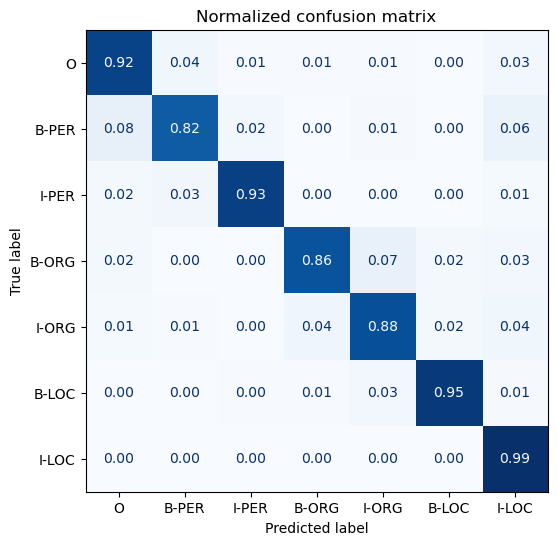

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(
    df_tokens["labels"],
    df_tokens["predicted_label"],
    tags.names
)

If this understanding is correct, we can reach these conclusions:

1. `B-PER` is most often mistaken for `O` at 0.07
1. `B-PER` is also often mistaken for `I-LOC` at 0.07
1. `B-ORG` is most often mistaken for `I-ORG` at 0.08

In [58]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({
            "tokens": tokens,
            "labels": labels,
            "preds": preds,
            "losses": losses
        }).T
        yield df_tmp


df["total_loss"] = df["loss"].apply(sum)

In [59]:
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,B-ORG,O,O,B-ORG,O,O,O,O,O,O,O
losses,0.00,0.00,5.43,0.00,0.00,0.00,10.27,8.84,8.94,6.98,7.67,0.00,7.66,7.90,0.00,7.80,7.85,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.22,0.00,0.00,7.68,8.18,8.07,4.82,0.00,8.12,8.88,7.54,6.95,4.02,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,5.72,5.85,6.01,0.00,5.91,0.00,5.71,0.00,5.38,6.19,6.12,6.02,5.40,5.07,0.00


#### A detail regarding parentheses, slashes being part of the named entities...

Recall earlier during the exercise where we were aggregating by tokens, and we had the following observation.

> (parentheses, slashes)... at the beginning of words are rarer, but have a relatively high average loss. What could explain this?

Let's take a closer look at some of the sequences where there are opening parentheses.

In [60]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,B-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.02,0.02,0.00,0.02,0.00


So apparently, this Pan-X dataset was generated automatically rather than by-hand, so it is _not_ "gold-standard": it is <u>"silver-standard"</u>.

In labelling named entities automatically, it seems that parentheses and slashes, etc. are included in the marked up labelling for named entities. This detail may be important if we had to take this model to production, _so always pay attention to the details!_

----

## Cross-Lingual Transfer

Now let's see how our `de`-trained model fares against `fr`, `it`, and `en` without any sort of additional training. This is cross-lingual transfer.

First we set up a simple function that will help us obtain the $F_{1}$ score given the `trainer` object instance and a certain `dataset`.

In [61]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

We'll keep the scores in a `dict` of `dict`s...

In [62]:
f1_scores = defaultdict(dict)

In [63]:
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.866


The above $F_{1}$ score should be greater than 0.86 on `de`, coming pretty close to our expectations.

But how will this `de`-trained model fare when French is passed in?

In [64]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


Not all that bad, _n'est-ce pas?_

Let's check the $F_{1}$ scores of our `de`-trained model against the other languages in `panx_ch`...

In [65]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [66]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score of [de] model on [fr] dataset: 0.704


In [67]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

F1-score of [de] model on [it] dataset: 0.681


In [68]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

F1-score of [de] model on [en] dataset: 0.589


Some observations:

* Any difference in $F_{1}$ performance can be attributed to how close the other languages are to `de`.
* But again, another factor is the quality of the training data.
* It is somewhat suprising that the cross-lingual transfer of `de` $\Rightarrow$ `en` appears to be worse than `de` $\Rightarrow$ `fr` as we know that German and English are closer cousins than German is with relation to French.

----

## When Does Zero-Shot Transfer Make Sense?

We've seen how the `de`-trained model can still perform suprisingly well on the other languages _without any further training._ 

Note that in our experiment above, our zero-shot transfer using a `de`-trained model on the `fr` dataset yielded an $F_{1}$ score of around 0.70.

But we surmise that if we were willing expend the effort (time and money!) to train a model using `fr` samples, we might see better results for `fr`. The question is, then: at what point (number of samples) we start seeing appreciable returns? And since data labelling it very expensive, would we really be willing to pay that price?

Let's just see the trends for $F_{1}$ scores as we vary the number of training data samples in training up an `fr` model.

In [69]:
def train_on_subset(dataset, num_samples):
    
    train_ds = (
        dataset["train"]
            .shuffle(seed=42)
            .select(range(num_samples))
    )
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    
    training_args.logging_steps = len(train_ds) // batch_size
    
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        tokenizer=xlmr_tokenizer
    )
    
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="training all pau!")
    
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict({
        "num_samples": [len(train_ds)],
        "f1_score": [f1_score],
    })

In [70]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

In [71]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.813200,1.367523,0.060852
2,1.326800,1.192996,0.171042
3,1.129500,1.120410,0.168573


,num_samples,f1_score
0,250,0.16176


...

In [72]:
acc = [metrics_df]

for num_samples in [500, 1000, 2000, 4000]:
    acc.append(train_on_subset(panx_fr_encoded, num_samples))
    
metrics_df = pd.concat(acc, ignore_index=True)

Epoch,Training Loss,Validation Loss,F1
1,1.495400,0.999074,0.258083
2,0.857500,0.680275,0.556608
3,0.595200,0.566666,0.663866


Epoch,Training Loss,Validation Loss,F1
1,1.222300,0.689663,0.560443
2,0.547400,0.426099,0.724510
3,0.328100,0.399687,0.757561


Epoch,Training Loss,Validation Loss,F1
1,0.804300,0.415566,0.727481
2,0.311500,0.340222,0.795269
3,0.222400,0.339431,0.806430


Epoch,Training Loss,Validation Loss,F1
1,0.613000,0.339830,0.769610
2,0.275200,0.320861,0.795033
3,0.178000,0.289707,0.829973


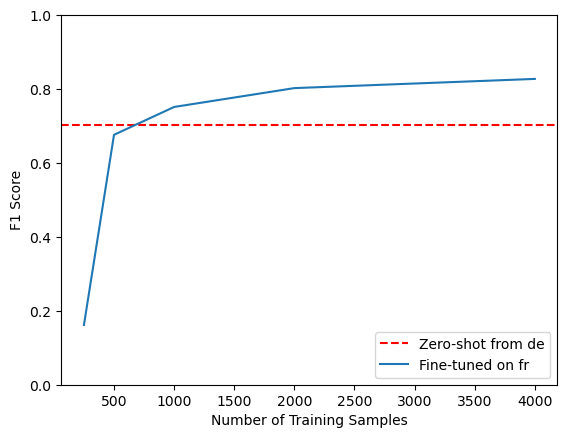

In [73]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0,1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

* So for the case of `fr`, zero-shot transfer is comparable to an `fr` fine-tuned model up until about 750 or so training samples. 
* You need to ask yourself, "Do you really need to spend the time and effort to obtain 750+ labelled training samples for `fr`?

----

## Fine-Tuning on Multiple Languages at Once

...

In [74]:
from datasets import concatenate_datasets

In [75]:
def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]
        ).shuffle(seed=42)
    return multi_corpus

In [76]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])
panx_de_fr_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 17160
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8580
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8580
    })
})

In [77]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer,
    train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"]
)

trainer.train()
trainer.push_to_hub(commit_message="Training all pau!")

Cloning https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-de-fr into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Download file pytorch_model.bin:   0%|          | 1.40k/1.03G [00:00<?, ?B/s]

Download file training_args.bin:  96%|#########6| 3.41k/3.55k [00:00<?, ?B/s]

Clean file training_args.bin:  28%|##8       | 1.00k/3.55k [00:00<?, ?B/s]

Download file tokenizer.json:   0%|          | 1.39k/16.3M [00:00<?, ?B/s]

Download file sentencepiece.bpe.model:   0%|          | 3.40k/4.83M [00:00<?, ?B/s]

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,F1
1,0.294800,0.189225,0.823070
2,0.149600,0.172804,0.846039
3,0.095800,0.170032,0.856378


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

To https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-de-fr
   961b21d..e91ec42  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-de-fr
   e91ec42..a110a25  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-de-fr/commit/e91ec422b8de854a176d0e6b7f5cecbb2f3b65ce'

In [78]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

F1-score of [de-fr] model on [de] dataset: 0.867


F1-score of [de-fr] model on [fr] dataset: 0.854


F1-score of [de-fr] model on [it] dataset: 0.807


F1-score of [de-fr] model on [en] dataset: 0.655


Note that we see a roughly 10-point increase in the $F_{1}$ scores for `it` and `en`! And just by additional training on `fr` along with `de`!

----

In [79]:
corpora = [panx_de_encoded]

In [80]:
# excluding de...
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    
    # fine-tune on this monolingual dataset
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    
    # collect F1-score for this trained model
    f1_scores[lang][lang] = metrics["f1_score"][0]
    
    # add this monolingual corpus to our list of corpora to cat
    corpora.append(ds_encoded)
    

Cloning https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-fr into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Download file pytorch_model.bin:   0%|          | 3.40k/1.03G [00:00<?, ?B/s]

Download file training_args.bin:  96%|#########6| 3.41k/3.55k [00:00<?, ?B/s]

Clean file training_args.bin:  28%|##8       | 1.00k/3.55k [00:00<?, ?B/s]

Download file tokenizer.json:   0%|          | 15.4k/16.3M [00:00<?, ?B/s]

Download file sentencepiece.bpe.model:   0%|          | 16.0k/4.83M [00:00<?, ?B/s]

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,F1
1,0.578100,0.369210,0.755213
2,0.269700,0.276838,0.828628
3,0.179700,0.275323,0.844886


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

To https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-fr
   5d3e0b4..234d608  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-fr
   234d608..bfdd778  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-it into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Download file pytorch_model.bin:   0%|          | 16.0k/1.03G [00:00<?, ?B/s]

Download file training_args.bin:  96%|#########6| 3.41k/3.55k [00:00<?, ?B/s]

Clean file training_args.bin:  28%|##8       | 1.00k/3.55k [00:00<?, ?B/s]

Download file sentencepiece.bpe.model:   0%|          | 3.40k/4.83M [00:00<?, ?B/s]

Download file tokenizer.json:   0%|          | 16.0k/16.3M [00:00<?, ?B/s]

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,F1
1,0.815200,0.351519,0.734177
2,0.287500,0.276477,0.809211
3,0.186900,0.249713,0.817661


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

To https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-it
   7539e78..b259324  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-it
   b259324..55e0b6e  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-en into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Download file pytorch_model.bin:   0%|          | 1.40k/1.03G [00:00<?, ?B/s]

Download file training_args.bin:  96%|#########6| 3.41k/3.55k [00:00<?, ?B/s]

Clean file training_args.bin:  28%|##8       | 1.00k/3.55k [00:00<?, ?B/s]

Download file sentencepiece.bpe.model:   0%|          | 15.4k/4.83M [00:00<?, ?B/s]

Download file tokenizer.json:   0%|          | 3.40k/16.3M [00:00<?, ?B/s]

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,F1
1,1.103600,0.662901,0.469227
2,0.521300,0.422717,0.662953
3,0.349000,0.400974,0.688616


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

To https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-en
   632b21d..2f8a1d6  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-en
   2f8a1d6..b169911  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [81]:
corpora_encoded = concatenate_splits(corpora)

In [82]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer,
    train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"]
)

trainer.train()
trainer.push_to_hub(commit_message="Panx-All training all pau!")

Cloning https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-all into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Download file pytorch_model.bin:   0%|          | 1.40k/1.03G [00:00<?, ?B/s]

Download file training_args.bin:  88%|########8 | 3.12k/3.55k [00:00<?, ?B/s]

Clean file training_args.bin:  28%|##8       | 1.00k/3.55k [00:00<?, ?B/s]

Download file sentencepiece.bpe.model:   0%|          | 16.0k/4.83M [00:00<?, ?B/s]

Download file tokenizer.json:   0%|          | 3.40k/16.3M [00:00<?, ?B/s]

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,F1
1,0.299300,0.190296,0.819518
2,0.158700,0.176670,0.838385
3,0.101700,0.175111,0.854796


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

To https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-all
   095ee1b..2a4eefe  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-all
   2a4eefe..2e74d55  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-all/commit/2a4eefed57425a9fdde1f25418f5c5e315710994'

In [83]:
for idx,lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

scores_data = {
    "de": f1_scores["de"],
    "each": {lang: f1_scores[lang][lang] for lang in langs},
    "all": f1_scores["all"]
}

f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(
    index="Fine-tune on",
    columns="Evaluated on",
    inplace=True
)

f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8660,0.7038,0.6806,0.5894
each,0.8660,0.8468,0.8251,0.7020
all,0.8674,0.8645,0.8690,0.7857


> Multilingual learning can provide significant gains in performance, especially if
> the low-resource languages for cross-lingual transfer belong to similar language
> families.
>
> ... We can see that German, French, and Italian achieve similar performance
> in the `all` category, suggesting that these languages are more similar
> to each other than than (they are) to English.
>
> ... it is a good idea to focus attention on cross-lingual transfer within 
> language families, especially when dealing with different scripts like
> Japanese.